# Step7: Variational AutoEncoder (VAE)

## VAE

In [1]:
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

/Users/naokimaekawa/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/naokimaekawa/Library/Python/3.9/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <760F3975-CB00-30FA-8785-26E85127AF0E> /Users/naokimaekawa/Library/Python/3.9/lib/python/site-packages/torchvision/image.so
  Expected in:     <5B060930-6A71-3C98-A456-D34B1C187A40> /Users/naokimaekawa/Library/Python/3.9/lib/python/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Hyperparameters

input_dim = 784 # x dimension
hidden_dim = 200 # Neurons in hidden layers
latent_dim = 20 # z dimension
epochs = 30
learning_rate = 3e-4
batch_size = 32

53.797113893636066
45.14594151611328
43.28120171712239
42.24678949991862
41.518136224365236
41.03317083536784
40.679787965901696
40.43573737182617
40.24585451456706
40.055663256835935
39.90016784464518
39.75652032063802
39.62523268839518
39.546291796875
39.46184066975911
39.37789673055013
39.30332707926432
39.2278143371582
39.140089271036786
39.09635790201823
39.0005842183431
38.93771435953776
38.9082132832845
38.86941021118164
38.82525197753906
38.714960546875
38.682077317301435
38.69303447672526
38.66713850097656
38.58518683878581


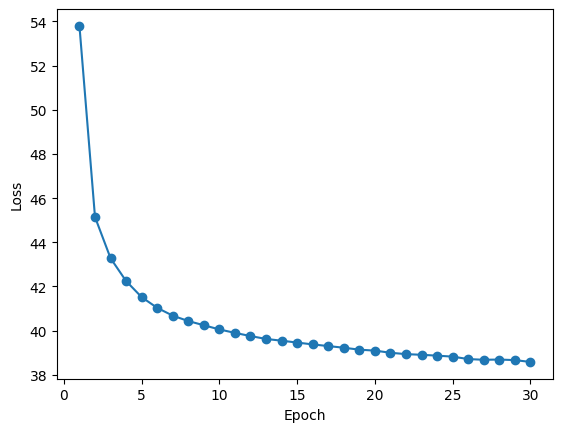

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)        
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        h = self.linear(x)
        h = F.relu(h)
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5 * logvar)
        return mu, sigma
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        x_hat = F.sigmoid(h)
        return x_hat
    
def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)
    z = mu + eps * sigma
    return z

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
    
    def get_loss(self, x):
        mu, sigma = self.encoder(x)
        z = reparameterize(mu, sigma)
        x_hat = self.decoder(z)
        
        batch_size = len(x)
        
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma ** 2) - mu ** 2 - sigma ** 2)
        return (L1 + L2) / batch_size
    
# Datasets

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(torch.flatten) # Flatten the image to vector.
])

dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0
    
    for x, label in dataloader:
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()
        
        loss_sum += loss.item()
        cnt += 1
        
    loss_avg = loss_sum / cnt
    print(loss_avg)
    losses.append(loss_avg)
    
# Plot losses
epochs = list(range(1, epochs + 1))
plt.plot(epochs, losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


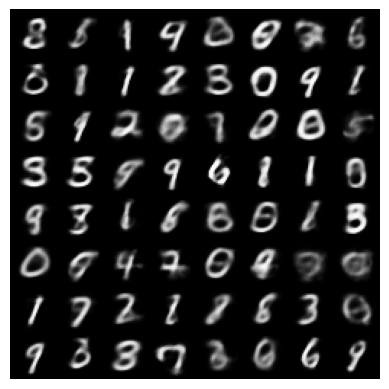

In [6]:
# generate new images
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, latent_dim)
    x = model.decoder(z)
    generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()